Because we have low sample size, a linear model with high bias and low variance will minimize overfitting when predicting OGTT glucose AUC.

Linear models are also good because they have robust tools for regularization to find a set of features that best predict OGTT. 

Using L1 regularization yields a model that tends to use SM 37:1 exclusively, and the weight for all other features is super low. 

Using L2 regularization just upweights all 200 TG-like features, and shrinks the coefficient for every other feature
    - This makes sense because TGs are very robust indicators of diabetes 
    
So either method by itself doesn't make a particularly useful model. 


Some options:
1. L1 regularization, except remove the top performing feature and then re-run model without it to find the next best. 

2. L2 regularization without TGs

3. Elastic net with custom tuning 

It's also worth showing the extent of the multi-colinearity to justify why we need to regularize in our quest for data-driven feature importance
Options: 
1. Show a clustered heatmap of pearson correlation
2. Calculate the variance inflation factor for each identified feature against all others 
    - Plot the V.I.F. for each feature in a stem plot
    - https://en.wikipedia.org/wiki/Variance_inflation_factor 
    - https://stats.stackexchange.com/questions/95082/pls-regression-and-collinearity

In [1]:
from collections import defaultdict
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.unicode_minus'] = False  # https://stackoverflow.com/questions/43102564/matplotlib-negative-numbers-on-tick-labels-displayed-as-boxes
plt.style.use('seaborn-ticks')  # 'seaborn-ticks', 'seaborn-white', 'seaborn'

import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
from src.utils import tight_bbox
from src.plots import plot_quant_vs_ogtt
import seaborn as sns
import dateutil

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV, Lasso, Ridge
from sklearn.cross_decomposition import PLSRegression

from sklearn.model_selection import (
    cross_val_score, cross_val_predict, cross_validate,
    RepeatedKFold, RepeatedStratifiedKFold, 
    StratifiedGroupKFold, GroupKFold, StratifiedKFold,
    train_test_split, 
    GridSearchCV,
    LeaveOneGroupOut,)
import sklearn
print(sklearn.__version__)

from statsmodels.stats.outliers_influence import variance_inflation_factor

1.0.2


In [2]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
colors['Non-fasted'] = colors['RBG']
colors['Fasted'] = colors['FBG']
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

In [3]:
X = data[data_cols].T
X_scaled = pd.DataFrame(StandardScaler().fit_transform(data[data_cols].T), index=data_cols, columns=data.index)

y_3class = fg['gluc_tol']                                                 # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_bg = fg['bg']                                                           # random/fasted blood glucoose
y_ogtt = fg['animal'].map(ap['OGTT (AUC)'])
y_weight = fg['animal'].map(ap['Weightprefastweek12'])
y_insulin = fg['animal'].map(ap['Insulin (AUC)'])

In [5]:
X_id = X_scaled.loc[:, data.loc[data['ID'] != 'Unidentified'].index]
X_id

i,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_11,m_13,m_16,m_17,m_19,m_20,m_21,m_22,m_25,m_26,m_27,m_28,m_31,m_32,m_33,m_34,m_35,m_37,m_38,m_40,m_41,m_43,m_45,m_46,m_54,m_56,m_58,m_60,m_61,m_64,m_65,m_66,m_68,m_72,m_75,m_76,m_77,m_78,m_79,m_80,m_81,m_84,m_86,m_88,m_90,m_93,m_95,l_0,l_1,l_2,l_3,l_4,...,l_727,l_731,l_738,l_740,l_741,l_747,l_753,l_754,l_756,l_758,l_759,l_760,l_765,l_771,l_774,l_777,l_780,l_782,l_785,l_790,l_791,l_794,l_797,l_802,l_803,l_804,l_805,l_806,l_808,l_815,l_819,l_826,l_828,l_831,l_833,l_835,l_841,l_844,l_852,l_854,l_856,l_860,l_862,l_865,l_866,l_871,l_873,l_876,l_878,l_888,l_890,l_892,l_893,l_895,l_900,l_905,l_907,l_908,l_910,l_912
1091_8_FBG,1.229019,1.536198,0.846416,-0.050953,-0.269333,-1.130265,-0.266355,0.061731,0.647281,0.336152,-0.460864,1.910065,-2.339412,-1.436501,0.811640,0.000493,0.313394,0.114660,-0.347532,-0.666154,-1.075282,0.142579,1.270917,-0.935217,-0.128624,0.276644,-0.857490,-0.631358,0.909177,-0.202143,0.686494,-0.896747,-0.713382,-0.335329,-0.124460,0.351785,-0.816472,-0.281408,-1.626131,-1.405938,-0.627543,-0.205349,0.513875,0.643425,-0.289059,-0.687066,1.768940,-0.210675,0.166842,1.095279,0.958301,0.278666,-0.430285,0.804490,-1.462444,-1.239039,-0.355517,-1.205340,0.990037,0.905001,...,-1.756673,-1.057937,-0.340708,-0.843159,-0.832331,-0.506198,-1.282854,-0.953487,-1.134743,-0.994578,-1.332389,-0.569682,-0.683833,-1.440081,-0.789121,-1.311497,-1.655192,-1.121278,-1.160219,-1.474159,-2.269668,-1.032724,-0.670134,-1.358516,-2.337118,-1.463013,-0.953714,-1.431232,-1.330469,-0.916826,-0.540288,-1.234453,-1.452055,-1.199499,-1.509583,-1.337946,-1.015887,-0.861304,-1.419365,-1.292728,-1.012499,-1.033412,-1.403901,-1.655136,-1.684767,-1.402175,-1.530948,-1.171703,-1.303802,-1.273455,-1.335528,-1.532042,-2.023310,-1.260969,-2.114683,-1.533031,-1.561124,-1.716919,-1.054728,-1.074026
1091_10_FBG,0.533221,1.174710,0.739283,0.132171,0.051373,-0.576451,-0.265027,-1.058962,0.676293,-0.953100,0.005036,0.352233,-1.331695,-1.378105,0.985253,-0.636247,0.429494,-0.053920,-0.042155,-1.051824,-1.046359,0.146569,-0.663966,0.716001,1.014224,-0.843319,-0.702396,-0.705905,0.238268,-0.462926,0.878425,0.651035,-0.749783,-0.439465,-0.912402,0.253519,-1.319006,0.505366,-1.804673,-1.410041,-0.634282,0.121177,1.704969,0.457281,-1.032390,-0.863808,1.729161,-0.363735,0.650837,-0.492427,1.389650,-0.132496,0.237240,-0.445899,-0.920265,-0.417207,0.392603,-0.862346,1.392424,1.309306,...,-0.859848,-0.324571,0.376597,-0.283487,-0.036586,0.075339,-0.428948,-0.178317,-0.694138,-0.620729,-0.996246,-0.264943,-0.054922,-1.539184,-0.569900,-0.665804,-1.133168,-0.620168,-0.672819,-0.475494,-0.585590,-0.566250,0.088683,-0.384260,-1.359881,-0.930821,0.013379,-1.183368,-0.641336,-0.596731,-0.768126,-0.754274,-1.216021,-0.761171,-1.058178,-0.495416,-0.161343,1.423170,-0.664854,-0.509952,-0.665207,-0.547794,-0.936842,-1.047355,-1.268599,-0.921529,-0.723208,-0.792765,-0.552242,-0.836269,-0.797264,-0.962689,-1.083146,-0.643463,-0.387013,-0.605897,-0.508650,-0.754984,-0.749764,-0.531201
1093_8_FBG,0.492781,1.037874,0.812384,0.147746,-0.141591,-0.548014,-0.325452,0.157906,-0.241991,0.757178,-0.215778,0.793838,-1.629933,-1.378912,0.950569,-0.381844,0.867139,-0.133960,0.000248,-0.933942,-0.745212,1.583239,0.521366,1.113247,0.939127,-0.182913,-1.796617,0.292169,1.326953,0.239695,0.939285,0.610735,-0.697577,-0.162400,-0.506225,0.337141,-0.944104,-0.232862,-0.861080,-0.853169,-0.282332,-0.061971,0.594878,0.857941,0.046677,-0.482591,0.757823,-2.631757,0.450367,0.045099,1.067329,0.753964,0.037383,-0.379067,-0.546307,-0.549991,0.625865,-0.722192,1.503401,1.158967,...,-1.313413,-0.237612,0.087548,-0.680783,-1.064488,-0.289136,-0.539476,-0.000415,-1.015569,-1.061009,-0.794728,-0.089124,-0.136548,-1.801051,-0.298130,0.138176,-1.514024,-0.546269,-0.318177,0.121157,-1.676378,-1.431876,0.118596,-0.123390,-0.733199,-0.675158,0.553958,-0.992805,-0.722175,-0.431557,-0.008785,-0.704282,-1.458818,-0.621322,-1.167489,-0.226526,-0.500530,1.724870,-0.678199,-0.191703

(array([262.,  94.,  26.,  32.,  10.,   6.,   4.,   3.,   0.,   3.]),
 array([5.10142141e+06, 4.42233932e+07, 8.33453650e+07, 1.22467337e+08,
        1.61589309e+08, 2.00711280e+08, 2.39833252e+08, 2.78955224e+08,
        3.18077196e+08, 3.57199168e+08, 3.96321139e+08]),
 <BarContainer object of 10 artists>)

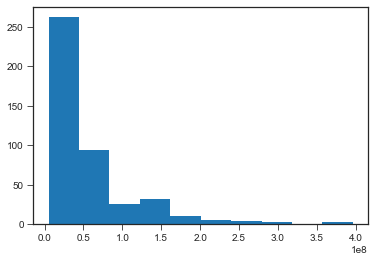

In [17]:
vifs = []
for idx in range(X_id.shape[1]):
    feature = X_id.columns[idx]
    vifs.append(variance_inflation_factor(X_id, idx))
plt.hist(vifs)

data_ids = data.loc[data['ID'] != 'Unidentified'].copy()
data_ids['vif'] = vifs
data_ids['vif'] 

### Distribution of variance inflation factors (VIF) for each identified feature against all other identified features
### Typically a VIF > 10 indicates strong co-linearity 
#### These values are all above 2e7 so biiiiig co-linearity 

This is another way of showing what a clustermap of Pearson correlation will show, that we have huge multi-colinearity


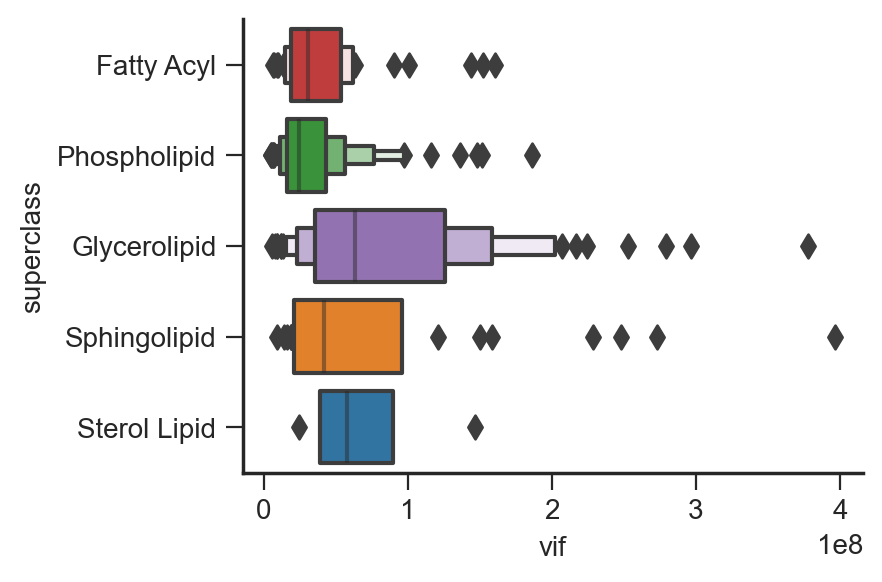

In [48]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
sns.boxenplot(
    data=data_ids.loc[data_ids['Type'] == 'lipid'], x='vif', y='superclass', ax=ax, palette=colors,
    orient='h')
# ax.legend(loc=(1, 0))
sns.despine()

In [47]:
data_ids

,unique_id,ID,m/z,RT,molec_class,Type,polarity,lc_type,superclass,1091_8_FBG,1091_10_FBG,1093_8_FBG,1093_9_FBG,1093_10_FBG,1060_8_FBG,1060_9_FBG,1060_10_FBG,1062_8_FBG,1062_9_FBG,1062_10_FBG,1074_8_FBG,1074_9_FBG,1074_10_FBG,1092_8_FBG,1092_9_FBG,1092_10_FBG,1102_8_FBG,1102_9_FBG,1102_10_FBG,1076_8_FBG,1076_9_FBG,1076_10_FBG,1082_8_FBG,1082_9_FBG,1082_10_FBG,1101_8_FBG,1101_9_FBG,1101_10_FBG,1091_8_RBG,1091_9_RBG,1091_10_RBG,1093_8_RBG,1093_9_RBG,1093_10_RBG,1060_8_RBG,1060_9_RBG,1060_10_RBG,1062_8_RBG,1062_9_RBG,1062_10_RBG,1074_8_RBG,1074_9_RBG,1074_10_RBG,1092_8_RBG,1092_9_RBG,1092_10_RBG,1102_8_RBG,1102_9_RBG,1102_10_RBG,1076_8_RBG,1076_9_RBG,1076_10_RBG,1082_8_RBG,1082_9_RBG,1082_10_RBG,1101_8_RBG,1101_9_RBG,1101_10_RBG,mean_sampling_log2fc,qval_sampling,qval_ogtt,qval_sampling:ogtt,pval_sampling,pval_ogtt,pval_sampling:ogtt,model_param_Intercept,model_param_sampling[T.RBG],model_param_ogtt,model_param_sampling[T.RBG]:ogtt,qval_fed,qval_fasted,pval_fed,coef_fed,intercept_fed,pval_fasted,coef_fasted,intercept_fasted,signif_interaction,signif_sampling,fasted_mean,fed_mean,Log2 Fold Change,Fed - Fasted slope,signif_interact,log_qval_sampling,log_qval_ogtt,log_qval_sampling:ogtt,is_id,lipid_class,extra_lipid_label,fa_carbons,fa_unsat,fa_carbon:unsat,pval_asterisks,vif
i,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
m_2,Urocanic acid_11.365_139.0503,Urocanic acid,139.05028,11.365,Nitrogen heterocycle,metabolite,+,HILIC,Nitrogen heterocycle,24.180859,23.583080,23.548337,22.368788,22.704412,23.895235,24.263211,23.084387,24.873347,24.131393,22.784459,23.535360,22.423151,22.803735,23.481692,22.430798,23.023717,23.664396,22.858647,24.128623,23.526511,21.831178,21.749389,24.120237,23.504340,24.157574,23.190847,22.483205,23.313011,23.697299,23.013379,23.900880,22.890781,23.843259,22.998299,23.754788,19.532128,23.528259,23.321162,22.090238,23.824082,22.736132,22.385239,23.103059,22.908987,23.219227,22.912440,22.576981,23.627151,20.875286,23.197122,23.932788,22.070212,23.062689,23.659398,23.628474,22.303258,23.273040,22.863585,-0.340412,1.783122e-01,0.583654,0.786750,1.371827e-01,0.479267,0.655532,23.388362,-0.005754,-0.000002,-0.000008,0.559487,0.922296,0.452673,-0.000010,23.382609,0.858745,-0.000002,23.388362,False,False,23.298066,22.957654,-0.340412,-0.000008,False,0.748819,0.233844,0.104163,True,NaN,NaN,NaN,NaN,NaN,ns,1.326927e+08
m_3,Uridine_7.513_243.0615,Uridine,243.06152,7.513,Nitrogen heterocycle,metabolite,-,HILIC,Nitrogen heterocycle,24.887680,24.713250,24.647222,24.526725,24.404735,24.714910,24.520405,24.792384,24.787384,24.408454,23.860085,24.340012,24.598038,24.425860,24.698939,24.405575,24.565564,25.019023,24.646051,24.693756,24.447097,23.689365,23.835635,24.588787,24.039980,24.419559,24.794463,24.319362,24.737902,24.341009,23.825238,23.799471,23.448487,24.316310,24.110271,24.235682,23.866956,23.998058,23.858506,23.615438,23.976836,23.062495,23.203653,23.915457,24.149017,23.965499,23.270248,23.803795,23.802189,23.856317,22.972609,23.271138,23.551153,24.212213,23.878109,24.069758,24.076382,23.794484,23.863370,-0.697301,3.289457e-10,0.129047,0.692928,8.404574e-11,0.071713,0.531018,24.869487,-0.886527,-0.000009,0.000004,0.525298,0.220950,0.412617,-0.000004,23.982960,0.067430,-0.000009,24.869487,False,True,24.500973,23.803672,-0.697301,0.000004,False,9.482876,0.889251,0.159312,True,NaN,NaN,NaN,NaN,NaN,ns,2.490868e+07
m_4,Uric acid_12.732_167.0201,Uric acid,167.02007,12.732,Nitrogen heterocycle,metabolite,-,HILIC,Nitrogen heterocycle,27.518513,27.163433,27.405718,27.051667,26.756463,17.148994,19.169210,27.209158,21.774699,23.189693,27.901315,23.781930,24.755634,27.816762,25.465603,26.869225,22.471185,19.180453,24.860989,26.471452,22.795611,16.674499,26.700629,18.348856,26.585272,26.977695,17.575513,26.709748,27.103362,23.314629,27.131485,26.912564,24.519750,26.201371,26.188412,17.431244,26.312933,25.956118,26.822243,27.438915,27.497491,27.053599,27.503475,27.148861,17

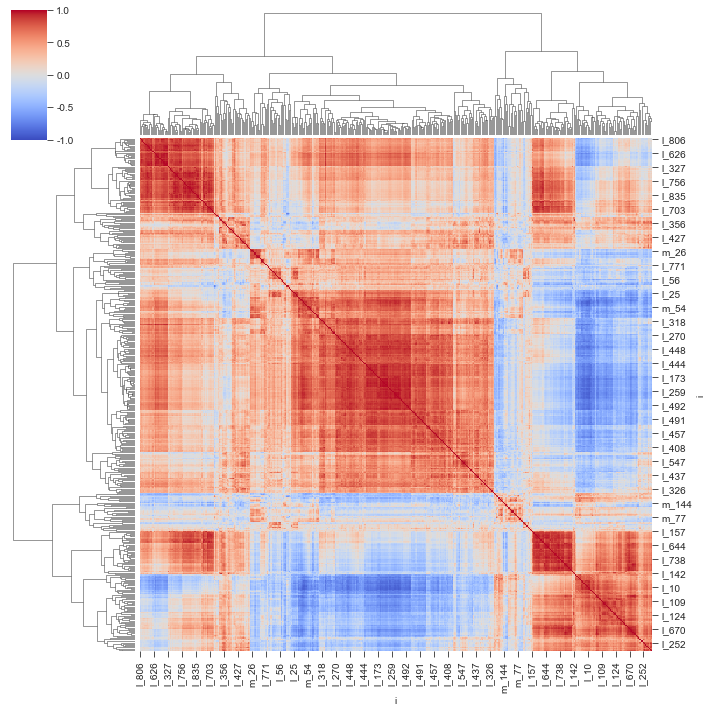

In [46]:
hm_data = data_ids[data_cols].T.corr('pearson')
sns.clustermap(
    data=hm_data, 
    cmap='coolwarm', vmin=-1, vmax=1,
    row_colors=
)

## Show that L1 regression is dumb because it picks only SM 37:1


## Show that L2 regression is dumb because it picks every single TG and shrinks everything else

## Play around with the parameters in Elastic net until diverse and biologically sensible features come out

## If Elastic net is too difficult, then chop the hierarchical clustering on method='complete' and metric='correlation' so that only 20-30 clusters remain
## Then, in each cluster, take the feature with the highest p-value in the quant_vs_ogtt for fed data, and use that as the paragon for that cluster 